In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
!unzip drive/MyDrive/'DIVP assignment'/"Copy of Database 1.zip"

Archive:  drive/MyDrive/DIVP assignment/Copy of Database 1.zip
 extracting: Database 1/apple-1.gif  
 extracting: Database 1/apple-10.gif  
 extracting: Database 1/apple-11.gif  
 extracting: Database 1/apple-12.gif  
 extracting: Database 1/apple-13.gif  
 extracting: Database 1/apple-14.gif  
 extracting: Database 1/apple-15.gif  
 extracting: Database 1/apple-16.gif  
 extracting: Database 1/apple-17.gif  
 extracting: Database 1/apple-18.gif  
 extracting: Database 1/apple-19.gif  
 extracting: Database 1/apple-2.gif  
 extracting: Database 1/apple-20.gif  
 extracting: Database 1/apple-3.gif  
 extracting: Database 1/apple-4.gif  
 extracting: Database 1/apple-5.gif  
 extracting: Database 1/apple-6.gif  
 extracting: Database 1/apple-7.gif  
 extracting: Database 1/apple-8.gif  
 extracting: Database 1/apple-9.gif  
 extracting: Database 1/bell-1.gif   
  inflating: Database 1/bell-10.gif  
 extracting: Database 1/bell-11.gif  
 extracting: Database 1/bell-12.gif  
 extracting: D

In [ ]:
import numpy as np
from sklearn.feature_extraction import image

one_image = np.arange(4 * 4 * 3).reshape((4, 4, 3))
one_image[:, :, 0]

patches = image.extract_patches_2d(one_image, (2, 2), max_patches=2,
    random_state=0)
patches.shape
patches[:, :, :, 0]

patches = image.extract_patches_2d(one_image, (2, 2))
patches.shape
patches[4, :, :, 0]

array([[15, 18],
       [27, 30]])

In [ ]:
reconstructed = image.reconstruct_from_patches_2d(patches, (4, 4, 3))

In [ ]:
np.testing.assert_array_equal(one_image, reconstructed)

In [ ]:
dataset_directory = 'Database 1'

In [ ]:
image_files = [f for f in os.listdir(dataset_directory) if f.endswith('.gif')]
image_files[:3]

['chopper-20.gif', 'personal_car-14.gif', 'personal_car-16.gif']

In [ ]:
selected_images = image_files[:10]
selected_images

['chopper-20.gif',
 'personal_car-14.gif',
 'personal_car-16.gif',
 'device6-4.gif',
 'hat-16.gif',
 'apple-10.gif',
 'butterfly-14.gif',
 'frog-15.gif',
 'lmfish-12.gif',
 'dog-1.gif']

First let's visualize the dataset

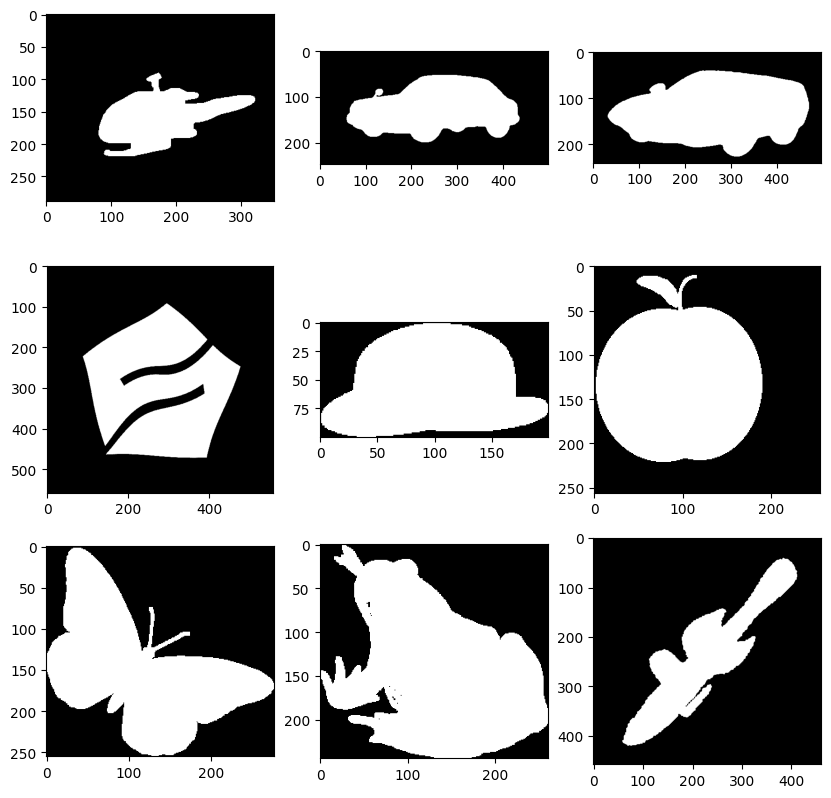

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  img_path = os.path.join(dataset_directory, selected_images[i])
  image = plt.imread(img_path)
  ax.imshow(image, cmap='gray')


plt.show()

# Feature Extraction

We will use Hu Moments which are a set of 6 numbers that are invariant to images transformations such as translation, scale, and rotation, and reflection.
The 7th moment's sign changes for reflection. This means that if an image has been transformed in any of these ways, the features will still be intact.

In [ ]:
def preprocess_image(image_path):
    # Read the image using Matplotlib
    image = plt.imread(image_path)

    # Normalize and convert to 8-bit depth if necessary
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)

    # Convert to grayscale if it is a color image
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    # Convert to binary
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Noise removal using opening morphological operation
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Invert the image for findContours
    inverted_image = cv2.bitwise_not(opening)

    # Find contours using the inverted binary image
    contours, hierarchy = cv2.findContours(inverted_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Fill the found contours (holes)
    for i in range(len(contours)):
        if hierarchy[0][i][3] != -1:  # Only fill the contours that have parents
            cv2.drawContours(opening, contours, i, (255,255,255), thickness=cv2.FILLED)

    # No need to invert the image back because we fill the contours with white on the inverted image
    # The result in 'opening' is now the processed image with filled holes

    resized_image = cv2.resize(opening, (256, 256), interpolation=cv2.INTER_AREA)

    return resized_image

In [ ]:
import cv2
import os
import numpy as np

def extract_hu_moments(image_path):
    image = preprocess_image(image_path)
    # image = plt.imread(image_path)

    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)

    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    moments = cv2.moments(binary_image)

    hu_moments = cv2.HuMoments(moments)

    hu_moments = -1 * np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    return hu_moments.flatten()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def extract_sift_features(image_path):
    # Read the image using Matplotlib
    image = plt.imread(image_path)

    # Normalize and convert to 8-bit depth if necessary
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)

    # Convert to grayscale if it is a color image
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    # Create a SIFT object
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # Handle case where no descriptors are found
    if descriptors is not None:
        # Process descriptors (e.g., flatten, BoW, etc.)
        # For simplicity, here we're just returning the raw descriptors
        return descriptors
    else:
        return np.zeros((1, 128))



array([[78., 94.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [22.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [13.,  7.,  0., ...,  0.,  0.,  0.],
       [24.,  3.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
test = plt.imread('Database 1/stef-15.gif')/255
print(test[150])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
dataset_directory = 'Database 1'

image_files = [(os.path.join(dataset_directory, f)) for f in os.listdir(dataset_directory) if f.endswith('.gif')]

image_files = sorted(image_files)
feature_vectors = []

for image_file in image_files:
    feature_vector = extract_hu_moments(image_file)
    if feature_vector is not None:
        feature_vectors.append(feature_vector)

feature_vectors = np.array(feature_vectors)

<ipython-input-207-1b45d35148ed>:23: RuntimeWarning: divide by zero encountered in log10
  hu_moments = -1 * np.sign(hu_moments) * np.log10(np.abs(hu_moments))
<ipython-input-207-1b45d35148ed>:23: RuntimeWarning: invalid value encountered in multiply
  hu_moments = -1 * np.sign(hu_moments) * np.log10(np.abs(hu_moments))


In [ ]:
feature_vectors[1]

array([ 3.19369878,  9.48669309, 11.34097431, 12.46646952, 24.37983334,
       17.21130388, 25.05129023])

In [ ]:
np.save('feature_vectors.npy', feature_vectors)

In [ ]:
feature_vectors = np.load('feature_vectors.npy')
feature_vectors[1]

array([ 3.19369878,  9.48669309, 11.34097431, 12.46646952, 24.37983334,
       17.21130388, 25.05129023])

# Model training

Now we will use K-Nearest Neighbors machine learning algorithm with k = 30 and train it.

In [ ]:
import pickle

# Save this list to a file
with open('sift_descriptors.pkl', 'wb') as file:
    pickle.dump(feature_vectors, file)

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

feature_vectors = np.load('feature_vectors.npy')


feature_vectors = np.nan_to_num(feature_vectors)

model_0 = NearestNeighbors(n_neighbors=30, algorithm='auto', metric='euclidean')


model_0.fit(feature_vectors)

def retrieve_images(query_features, nn_model):
    distances, indices = nn_model.kneighbors([query_features])
    return indices[0]

query_image_path = 'Database 1/apple-10.gif'
query_features = extract_hu_moments(query_image_path)
similar_images_indices = retrieve_images(query_features, model_0)



In [ ]:
similar_images_indices

array([  5, 138,  92,  68, 161, 181,  72, 152, 145,  97,  37, 342,  81,
       221, 208, 399, 185, 261, 155,   9, 344,  60,  17, 279, 200, 128,
       108, 144, 156, 321])

In [ ]:
def get_similar_images(indices):
  similar_images = []
  for i in indices:
    similar_images.append(image_files[i])
  return similar_images

In [ ]:
feature_vectors = np.load('feature_vectors.npy')

feature_vectors = np.nan_to_num(feature_vectors)

model_1 = NearestNeighbors(n_neighbors=100, algorithm='auto', metric='euclidean')
model_1.fit(feature_vectors)


NearestNeighbors(metric='euclidean', n_neighbors=100)

In [ ]:
query_image_path = 'Database 1/apple-1.gif'
query_features = extract_hu_moments(query_image_path)
similar_images_indices = retrieve_images(query_features, model_1)

<ipython-input-22-452d87e531c3>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Error in callback <function _draw_all_if_interactive at 0x79d9a81fadd0> (for post_execute):


KeyboardInterrupt: 

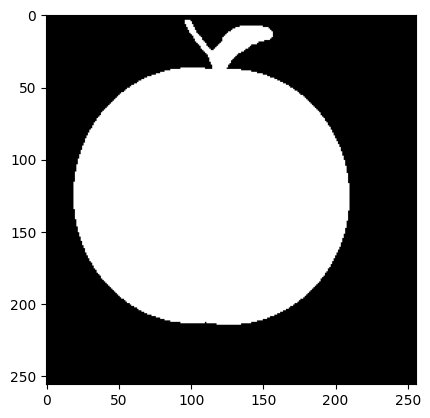

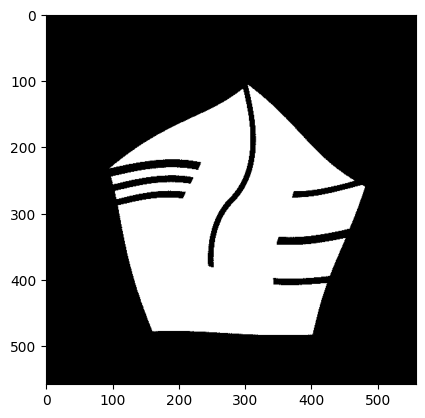

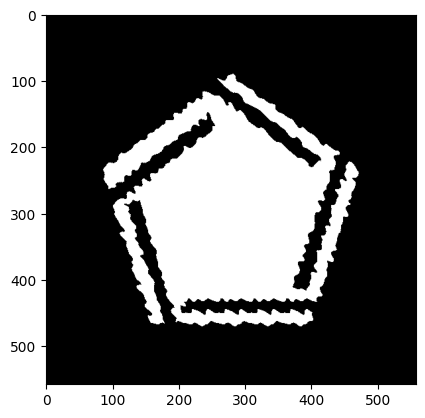

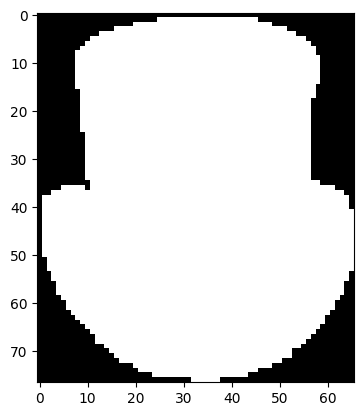

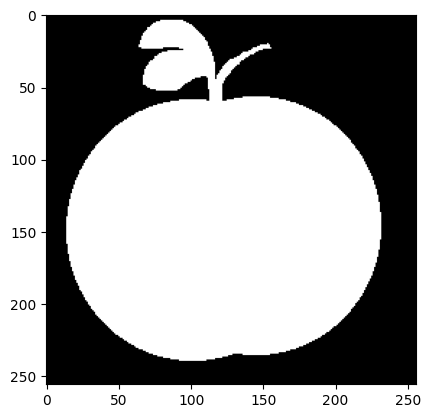

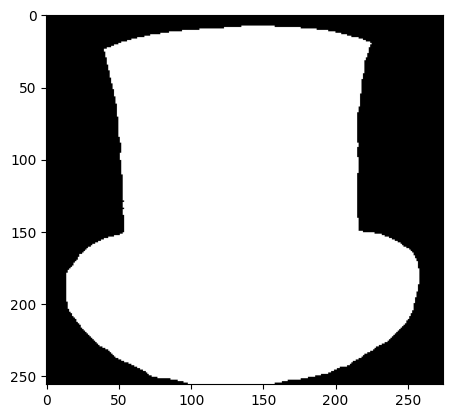

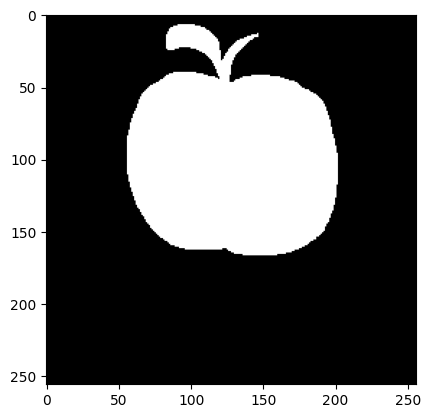

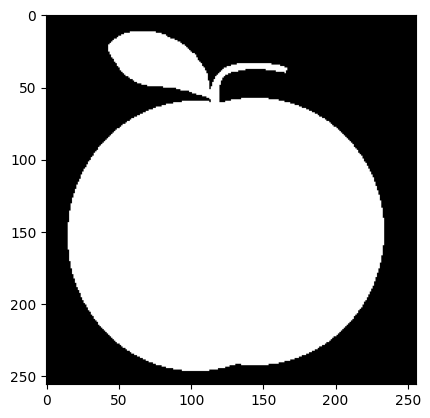

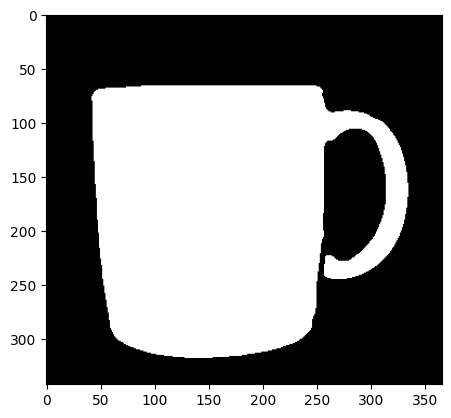

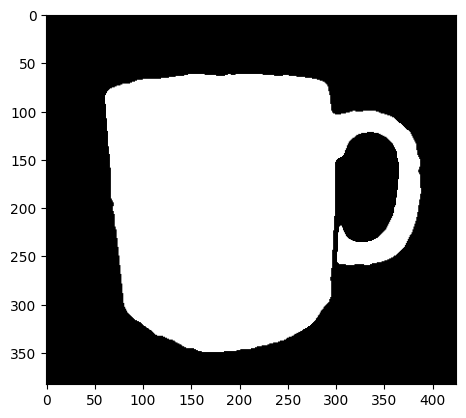

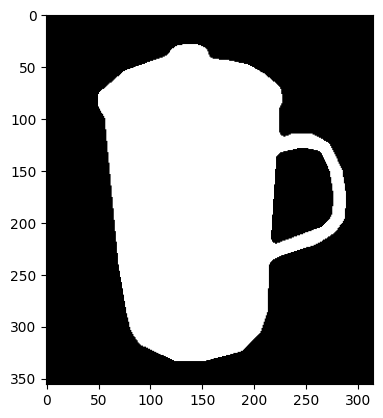

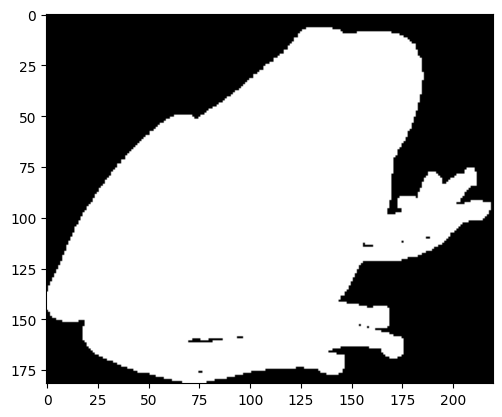

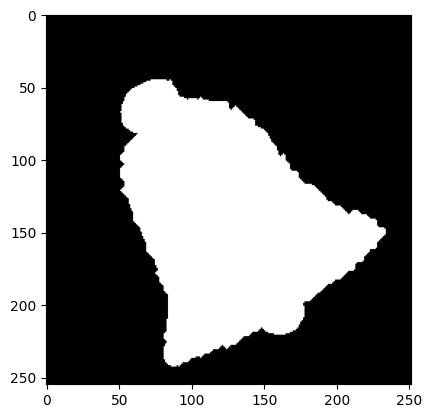

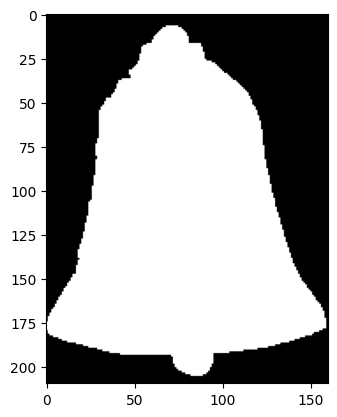

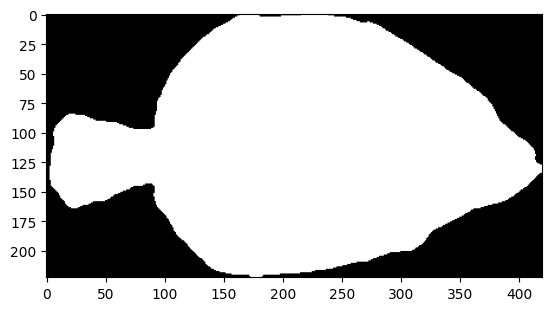

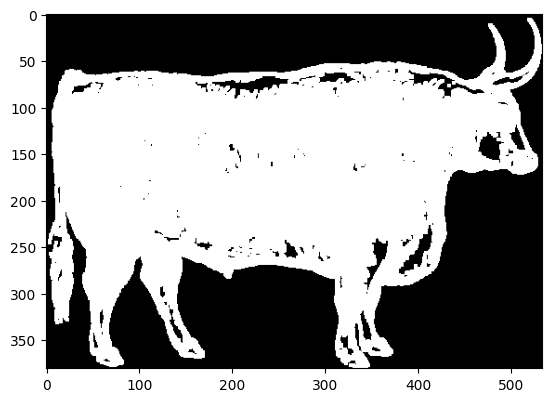

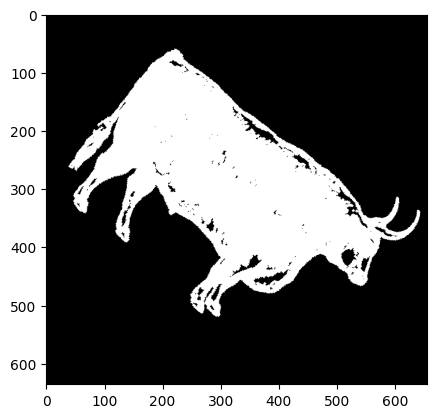

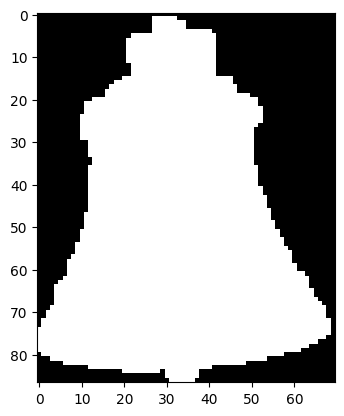

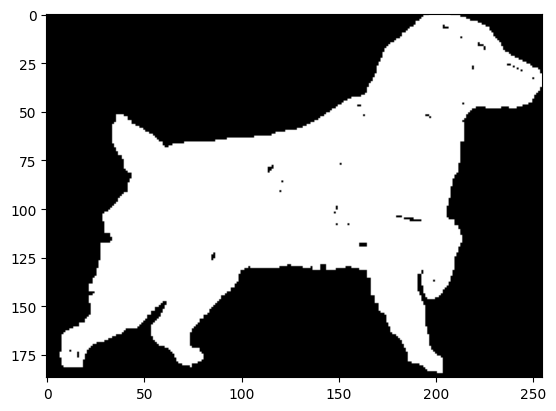

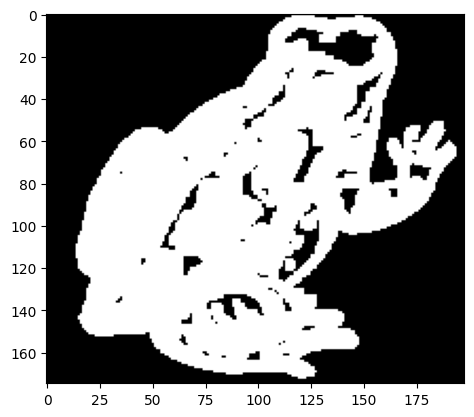

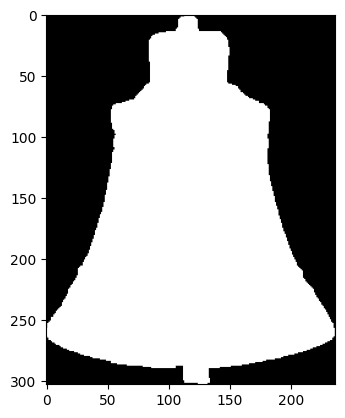

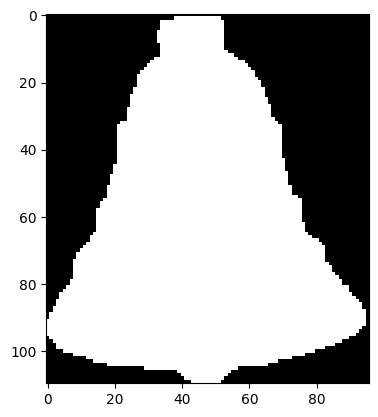

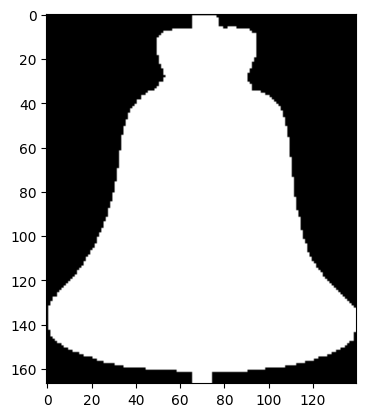

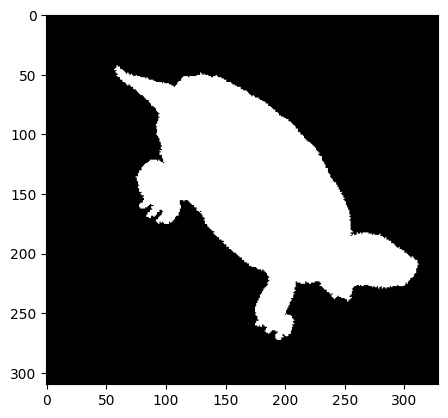

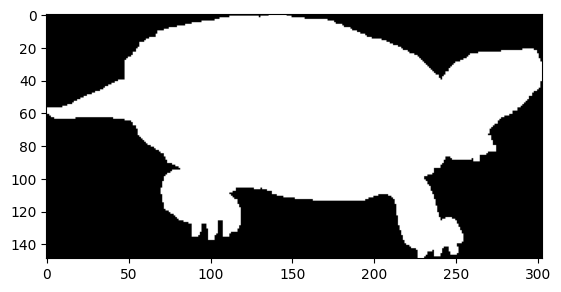

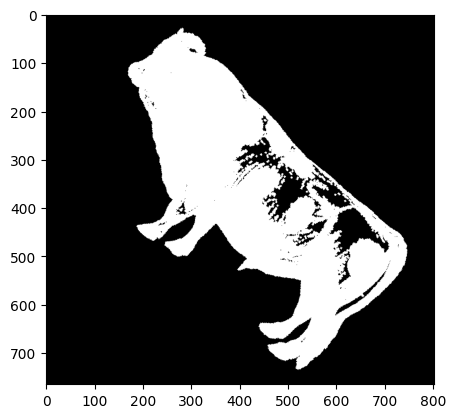

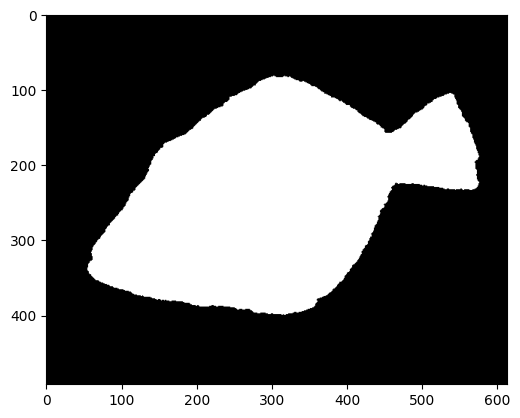

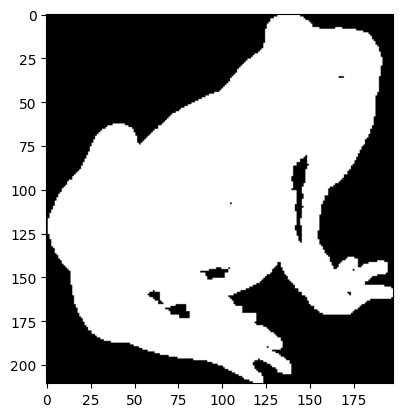

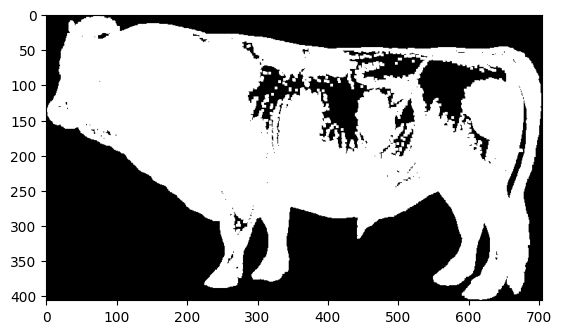

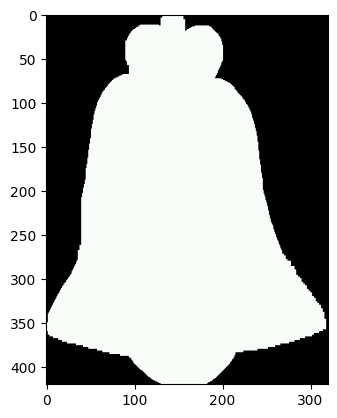

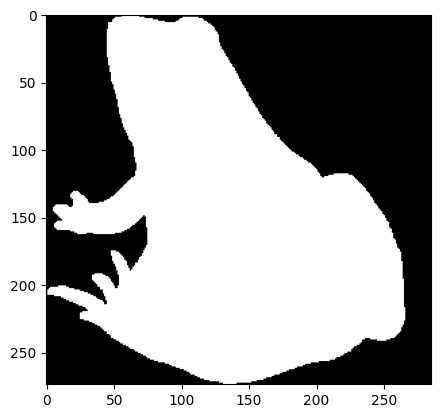

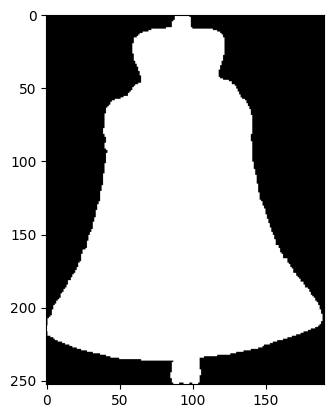

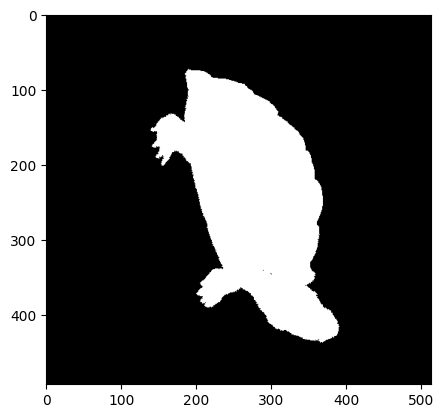

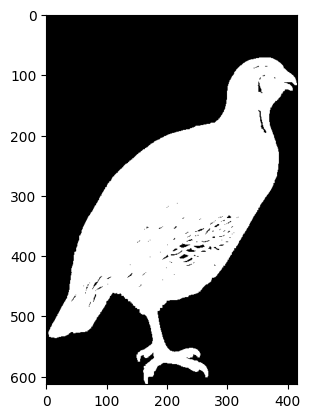

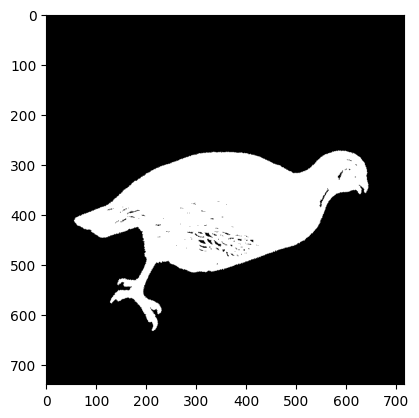

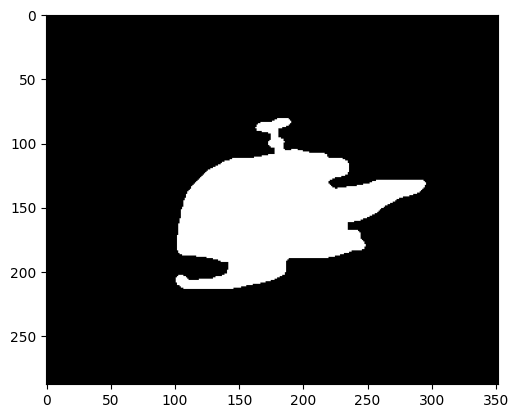

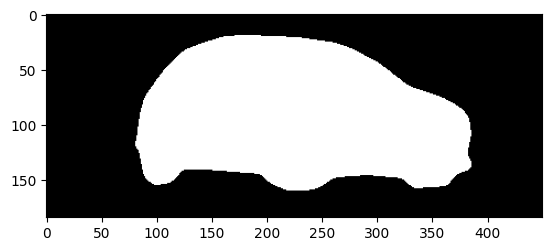

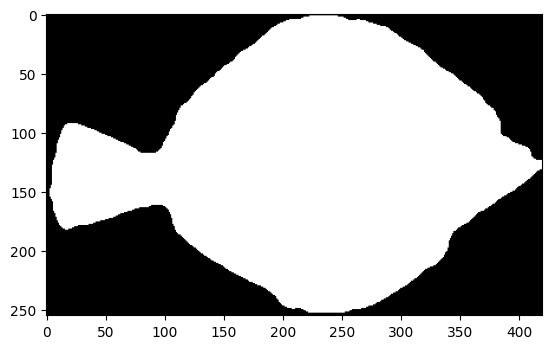

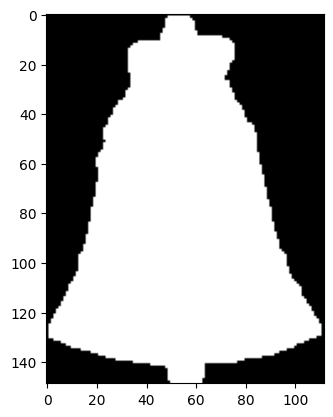

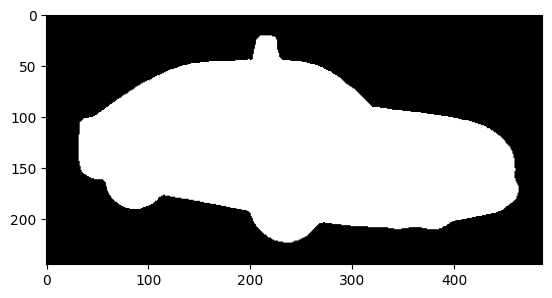

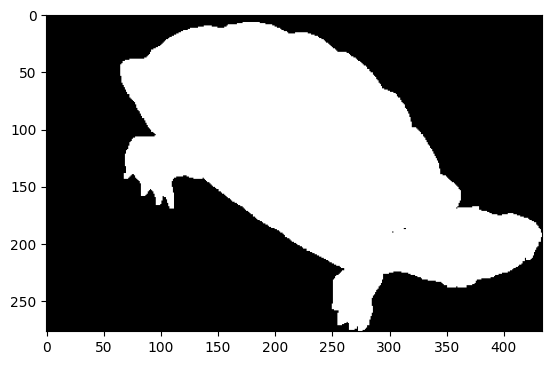

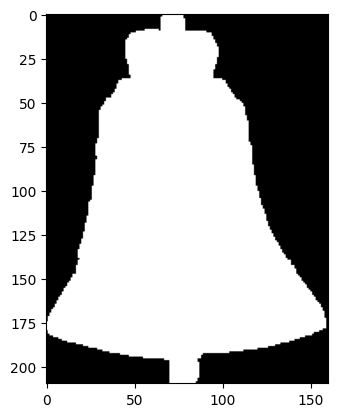

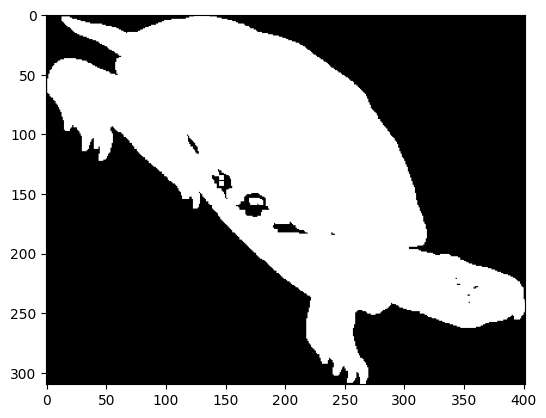

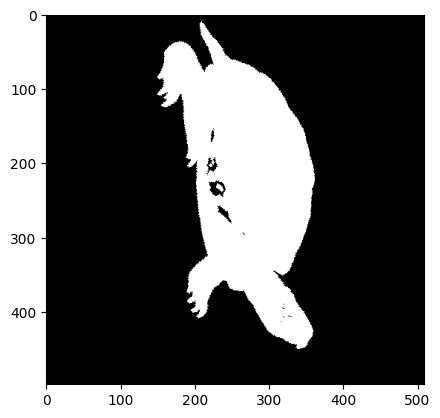

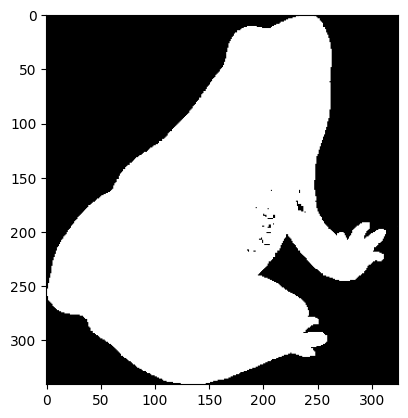

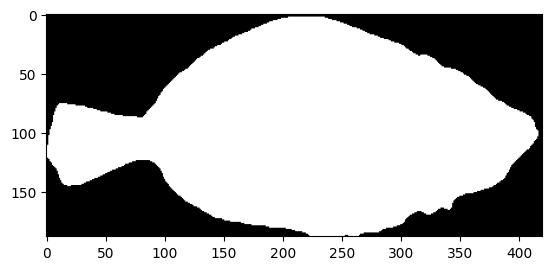

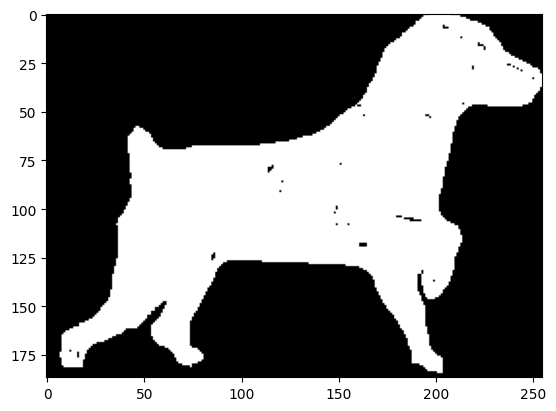

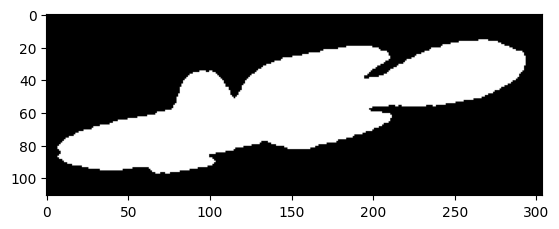

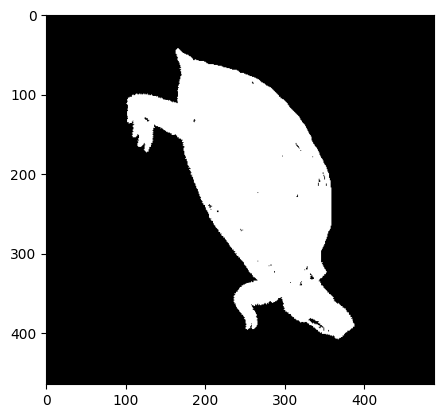

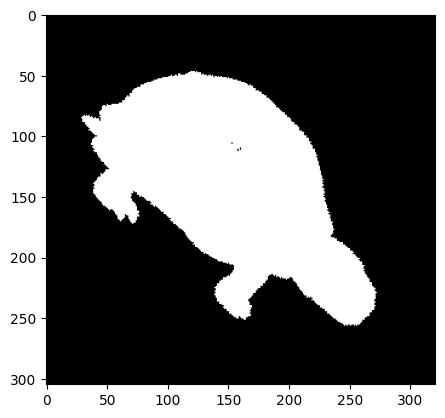

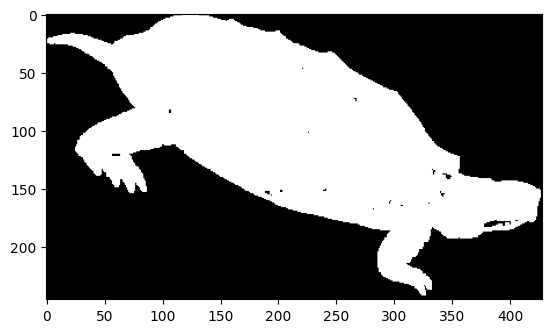

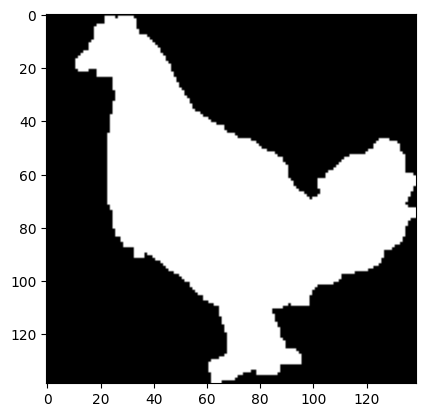

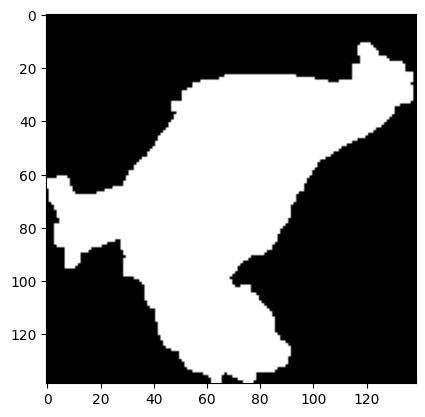

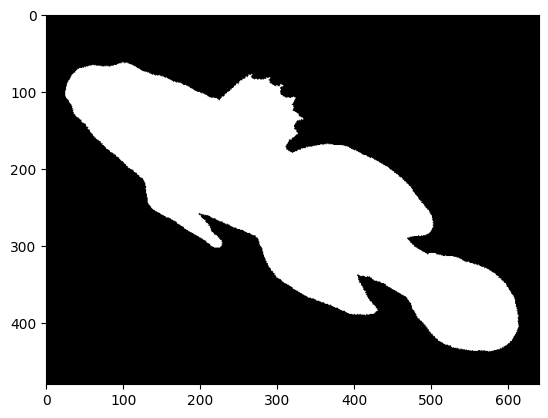

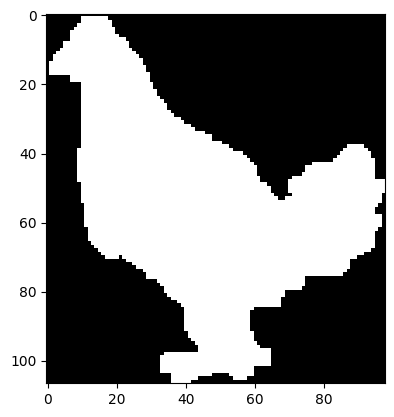

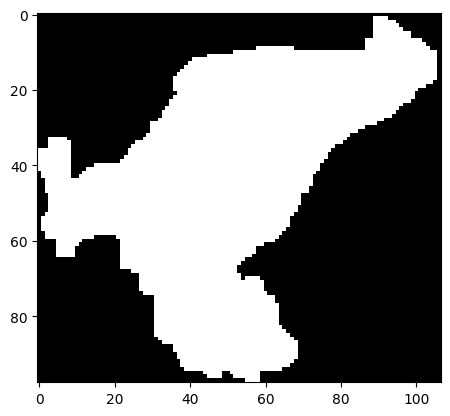

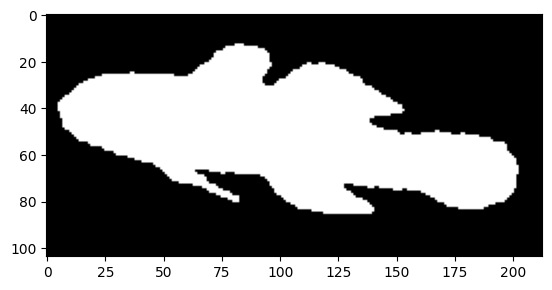

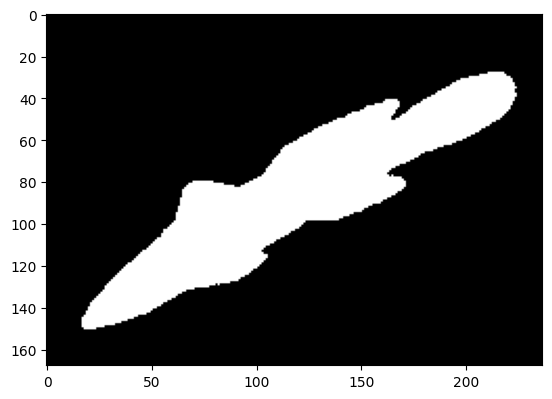

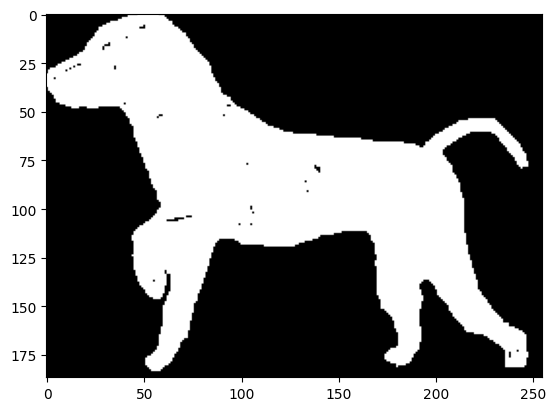

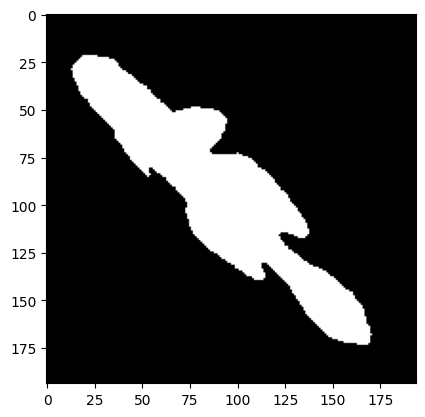

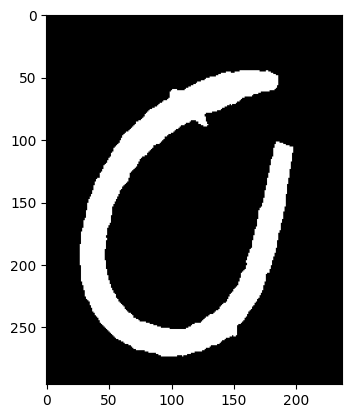

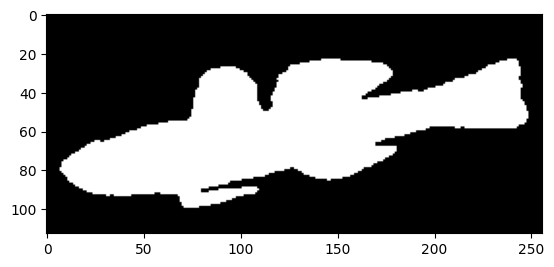

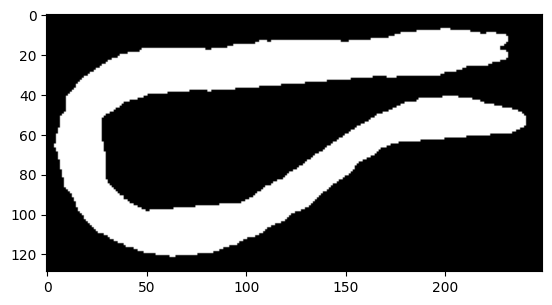

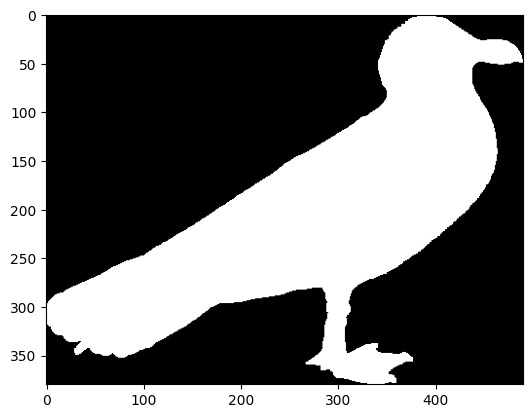

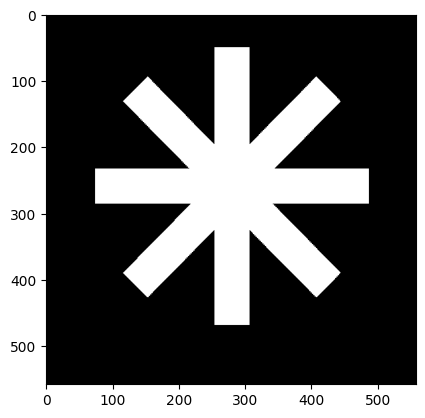

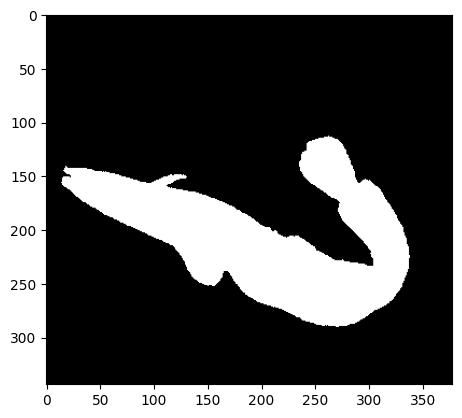

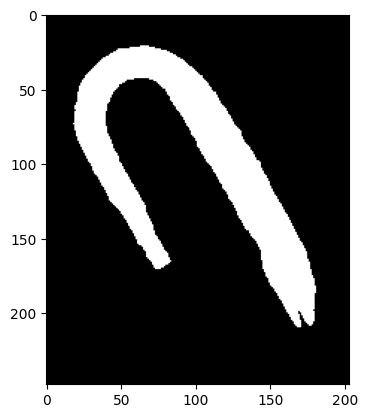

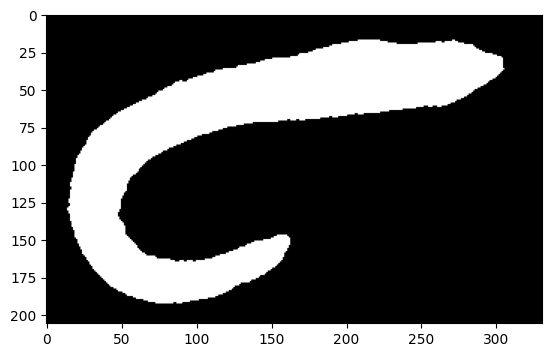

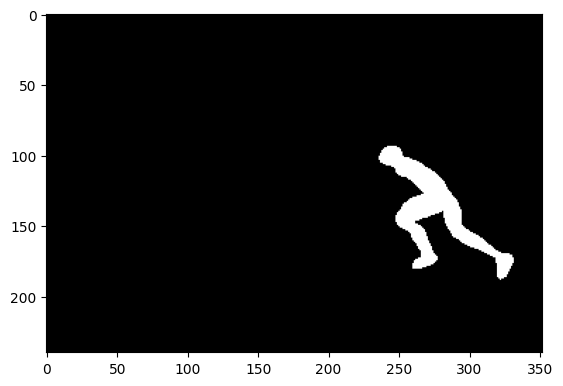

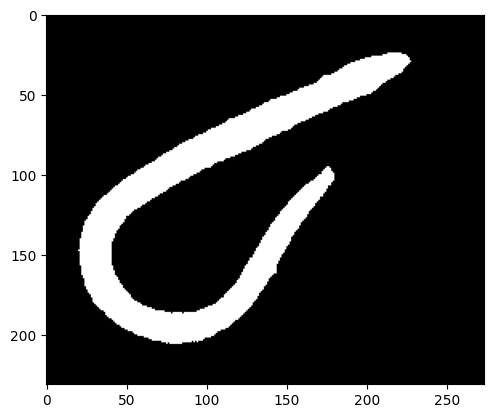

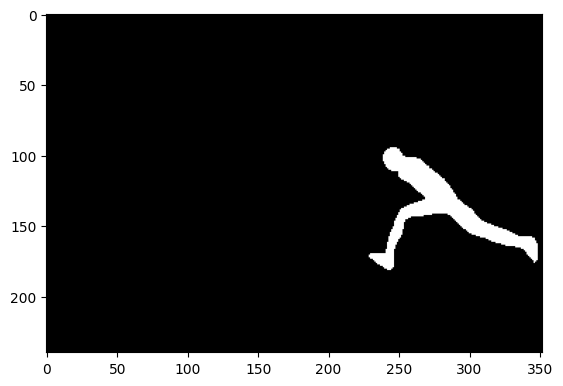

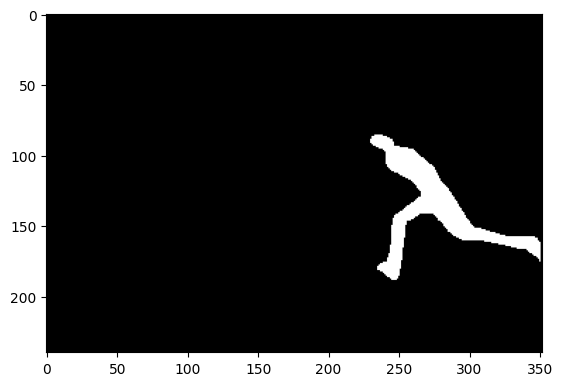

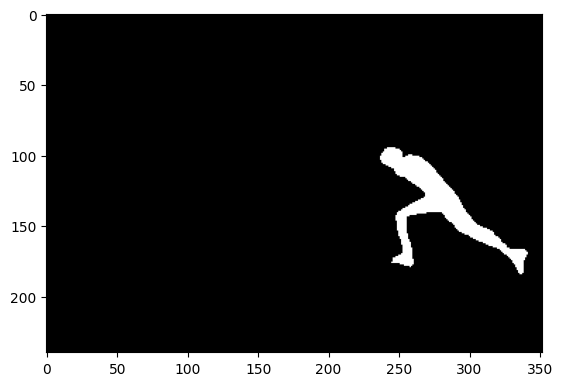

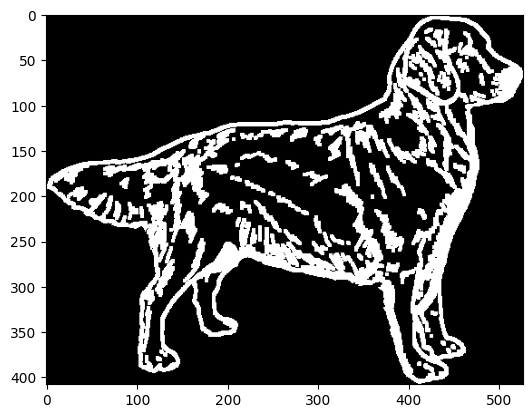

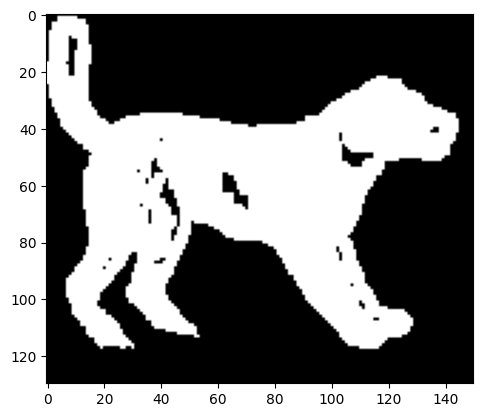

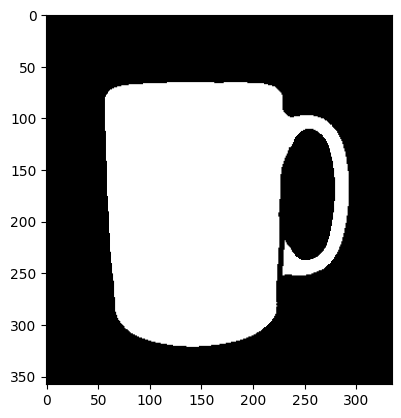

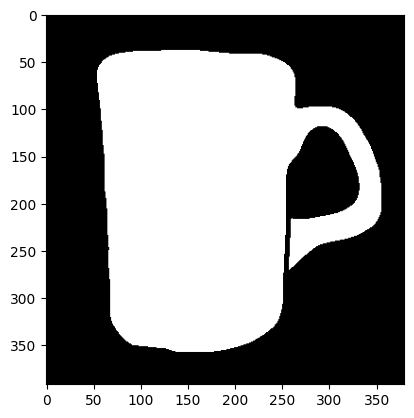

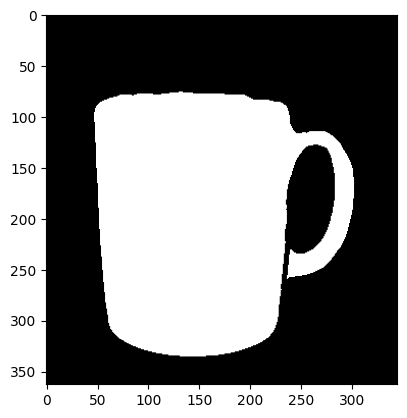

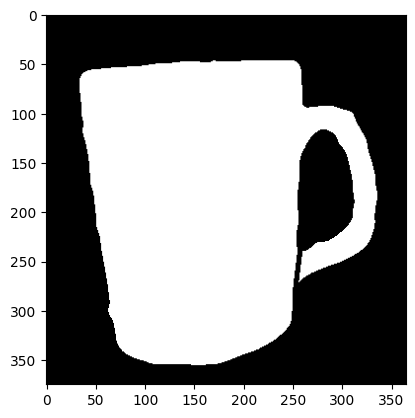

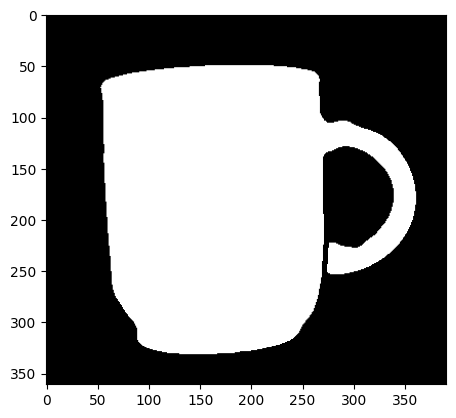

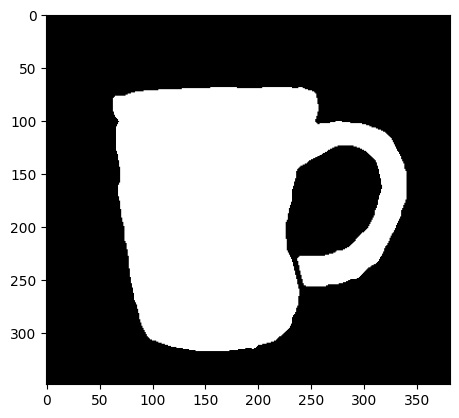

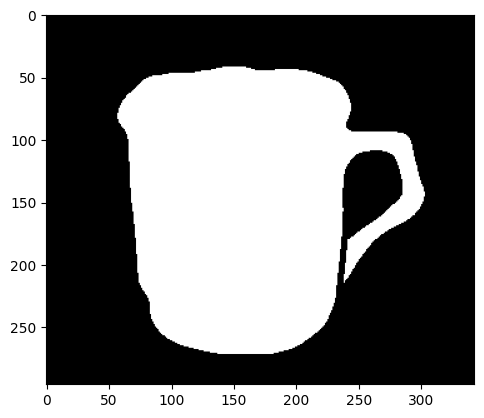

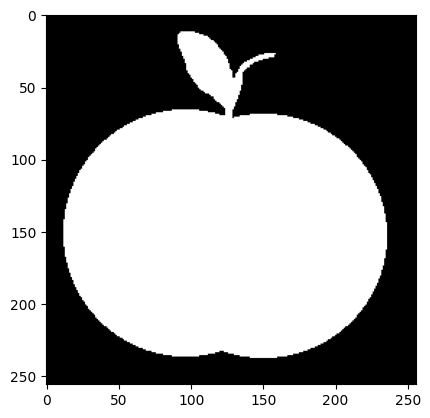

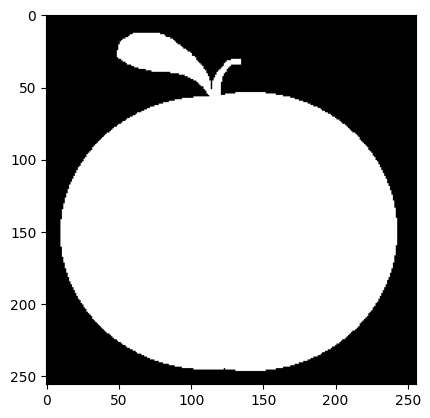

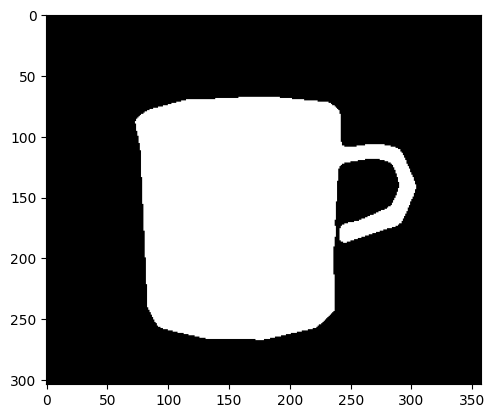

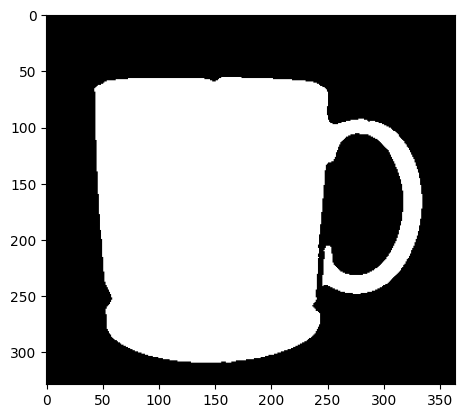

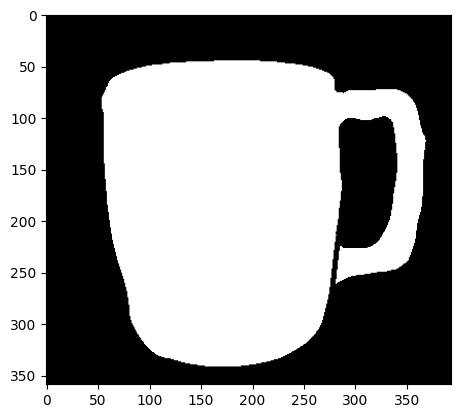

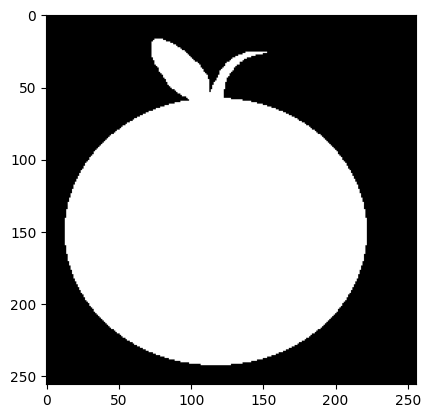

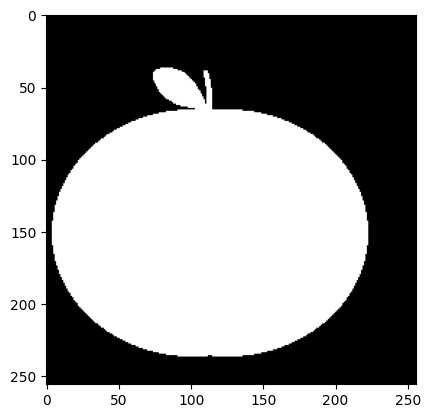

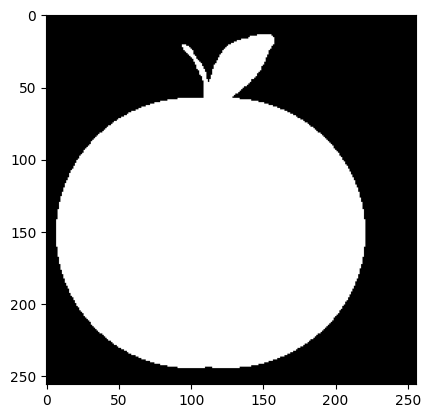

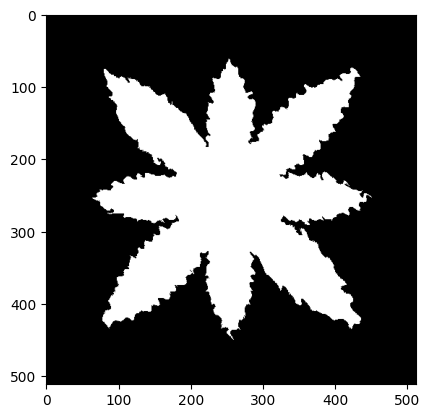

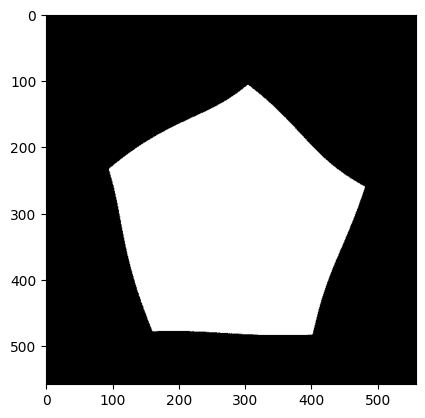

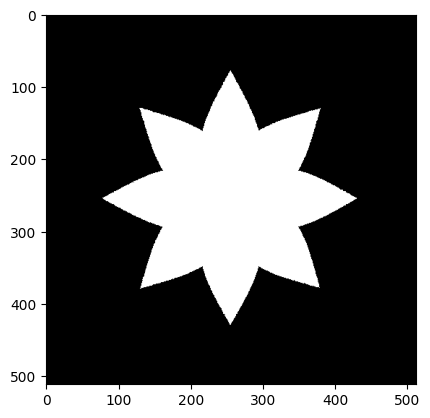

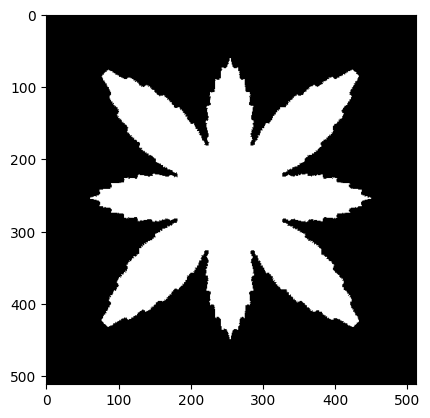

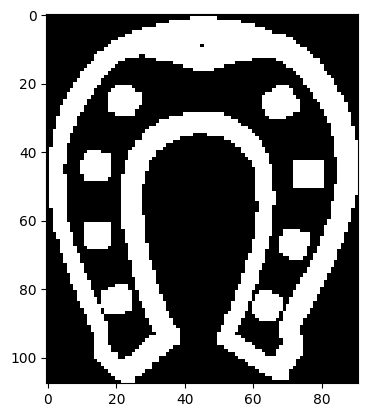

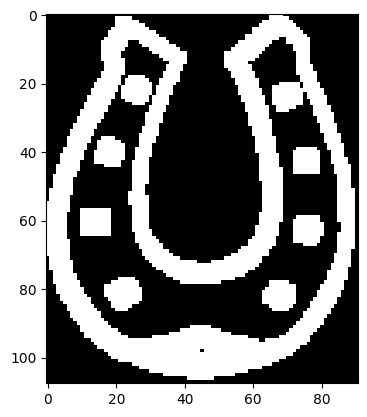

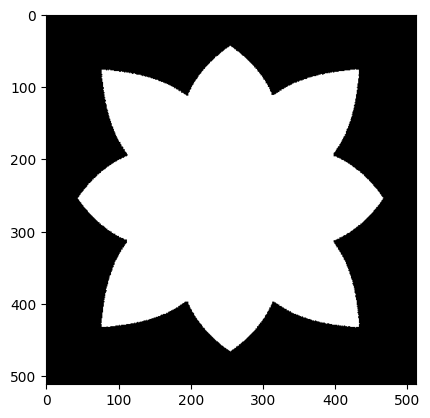

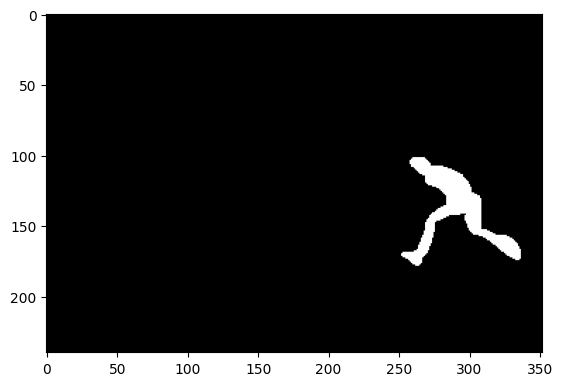

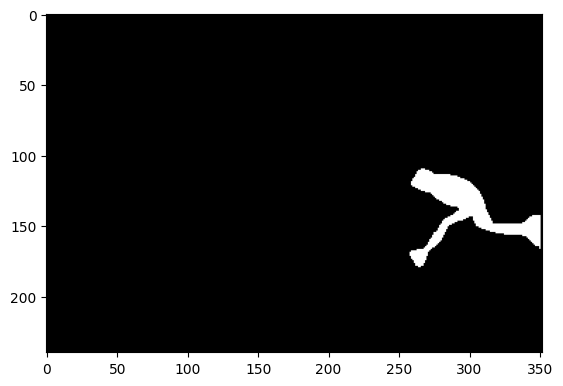

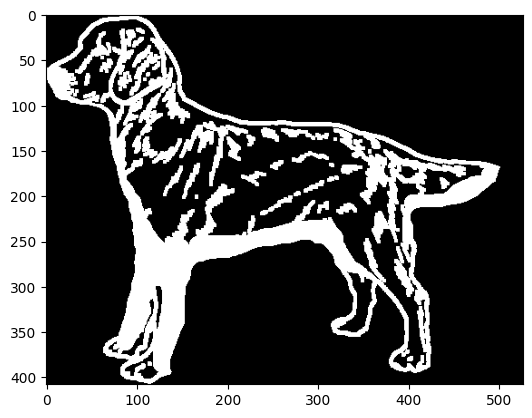

In [ ]:
similar_images = get_similar_images(similar_images_indices)
for i, image in enumerate(similar_images):
  similar = plt.imread(similar_images[i])
  plt.figure()
  plt.imshow(similar, cmap='gray')

In [ ]:
from scipy.spatial.distance import euclidean
def compute_distance(vector1, vector2):
  return cv2.matchShapes((vector1), (vector2), cv2.CONTOURS_MATCH_I3, 0)



In [ ]:
def rank_images_by_similarity(query_features, dataset_features):
    distances = [compute_distance(query_features, features) for features in dataset_features]
    ranked_indices = np.argsort(distances)
    return ranked_indices

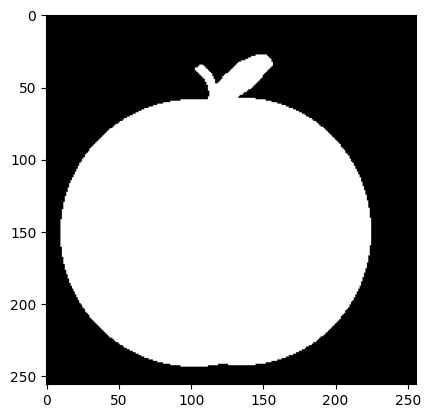

In [ ]:
plt.imshow(plt.imread('Database 1/apple-6.gif'), cmap='gray')

In [ ]:
def display_images(top_n_image_paths):
  for i, file in enumerate(top_n_images):
    image = plt.imread(file)
    plt.subplot(6, 5, i + 1)
    plt.imshow(image, cmap='gray')

In [ ]:
query_features = extract_hu_moments('Database 1/apple-1.gif')

ranked_indices = rank_images_by_similarity(query_features, feature_vectors)

In [ ]:
N = 30
top_n_indices = ranked_indices[:N]

top_n_images = [image_files[i] for i in top_n_indices]

In [ ]:
query_features, feature_vectors[76]

(array([  3.09852905,   7.06037719,  10.02560222,  11.08830188,
        -21.64647394, -14.61936138, -22.77106071]),
 array([  3.09852905,   7.06037719,  10.02560222,  11.08830188,
        -21.64647394, -14.61936138, -22.77106071]))

In [ ]:
image_files[23]

'Database 1/bell-12.gif'

In [ ]:
image_files.index('Database 1/apple-1.gif')

0

In [ ]:
compute_distance(feature_vectors[76], feature_vectors[76])

0.0

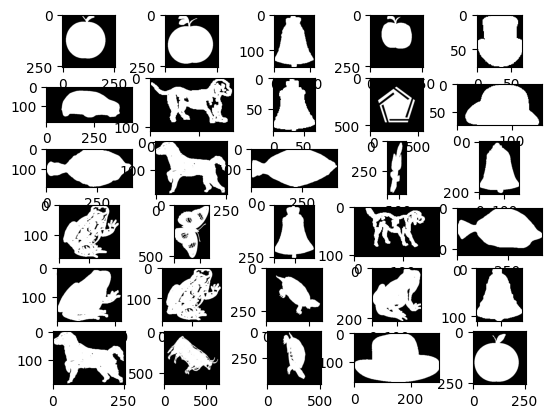

In [ ]:
display_images(top_n_images)

In [ ]:
image_files[0]

'Database 1/chopper-20.gif'

In [ ]:
def display_image(path):
  img = plt.imread(path)
  plt.imshow(img)

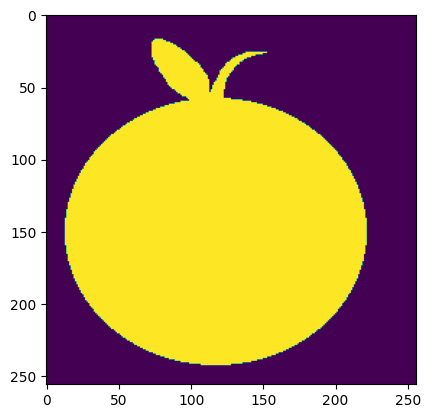

In [ ]:
display_image('Database 1/apple-7.gif')

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Assuming you have an array of Hu moments for all images
hu_moments = np.array([extract_hu_moments(image_file) for image_path in image_files])

# Create and fit the Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=5)  # Choose an appropriate number of neighbors
nn_model.fit(hu_moments)

NearestNeighbors()

In [ ]:
query_features = extract_hu_moments(query_image_path)
distances, indices = nn_model.kneighbors([query_features])

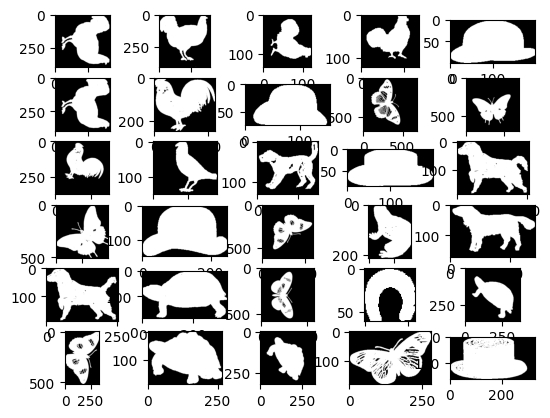

In [ ]:
# Retrieve the top N most similar images
top_n_indices = indices.flatten()[:5]  # Adjust the number as needed
top_n_image_paths = [image_files[i] for i in top_n_indices]

# Display the images
display_images(top_n_image_paths)  # Use the function you've used before to display images